<a href="https://colab.research.google.com/github/rrl7012005/Tensor-Flow-Computer-Vision-Course/blob/main/Malaria_Part_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plots
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import io
import os
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1
from tensorboard.plugins.hparams import api as hp
from google.colab import drive

In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info = True, download = True, as_supervised=True, shuffle_files=True, split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  dataset_size = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*dataset_size))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*dataset_size)) #Skips the first few elements
  val_dataset = val_test_dataset.take(int(VAL_RATIO*dataset_size))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*dataset_size))

  return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [ ]:
IM_SIZE = 224
@tf.function
def resizing(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255, label

In [ ]:
train_dataset = train_dataset.map(resizing)
val_dataset = val_dataset.map(resizing)
test_dataset = test_dataset.map(resizing)

batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(batch_size).prefetch(tf.data.AUTOTUNE)

Sometimes different types of models (sequential, functional etc.) is needed. Sequential is a stack of layers in a sequence.

Consider classifying one output as parasitic, one as position of cell in the image so thats 2 outputs of the model. We cant do this with the sequential API.

Functional API can create more complex models. Such as an output of one layer is concatenated with output of another layer and send that into the next layer. Not necessarily just sequential layers.


First few layer classifies useful info from images and last few layers classify infectious status.

Hashtag is the whole model.

We can separate into the feature extraction part and classification part.

In [ ]:
# IM_SIZE = 224
# func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

# #Pass functional input into conv layer and keeping passing through each layer
# x = Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(func_input)
# x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=2, strides=2)(x)

# x = Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(x)
# x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=2, strides=2)(x)

# x = Flatten()(x)

# x = Dense(100, activation="relu")(x)
# x = BatchNormalization()(x)

# x = Dense(10, activation="relu")(x)
# x = BatchNormalization()(x)

# func_output = Dense(1, activation="sigmoid")(x)

# lenet_model = Model(func_input, func_output, name = "Lenet_Model")
# lenet_model.summary()

In [ ]:
IM_SIZE = 224
reg_rate = 0.01
dropout_rate = 0.2
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu', kernel_regularizer=L2(reg_rate))(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)
x = Dropout(dropout_rate)(x)

x = Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu', kernel_regularizer=L2(reg_rate))(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)

feature_extractor = Model(func_input, output, name = "Feature_Extractor")
feature_extractor.summary()

Model: "Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input Image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,136 (4.44 KB)

 Trainable params: 1,092 (4.27 KB)

 Non-trainable params: 44 (176.00 B)

In [ ]:
IM_SIZE = 224
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_extractor(func_input)
#TF models are callable like layers in TF

x = Flatten()(x)

x = Dense(100, activation="relu", kernel_regularizer=L2(reg_rate))(x)
x = BatchNormalization()(x)

x = Dense(10, activation="relu", kernel_regularizer=L2(reg_rate))(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

lenet_model = Model(func_input, func_output, name = "Lenet_Model")
lenet_model.summary()

Model: "Lenet_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input Image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Feature_Extractor (Functional)       │ (None, 54, 54, 16)          │           1,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

The feature extraction part could even be a sequential api instead of functional.

#Model Subclassing



Allows us to create layers whose attributes are other layers. Can make it easier to build more compelx models. Inherits from the layer class. Good Practice to build models like this. Example below:

In [ ]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(FeatureExtractor, self).__init__()
    #Can use layers as the attributes

    self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size = pool_size, strides=2 * strides)

    self.conv_2 = Conv2D(filters = filters * 2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size = pool_size, strides=2 * strides)

  def call(self, x):

    #Training paramter can tell us whether or not to use a given layer in training
    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)
    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)



Create the  model again

In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_sub_classed(func_input)

x = Flatten()(x)

x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation="relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

lenet_model = Model(func_input, func_output, name = "Lenet_Model")
lenet_model.summary()

Model: "Lenet_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input Image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_extractor (FeatureExtractor) │ (None, 54, 54, 16)          │           1,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,649 (17.81 MB)

 Trainable params: 4,668,381 (17.81 MB)

 Non-trainable params: 268 (1.05 KB)

OR Can do the thing for the whole model as well

In [ ]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()
    #Can use layers as the attributes

    self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)
    self.flatten = Flatten()
    self.dense_1 = Dense(100, activation="relu")
    self.batch_1 = BatchNormalization()
    self.dense_2 = Dense(10, activation="relu")
    self.batch_2 = BatchNormalization()
    self.dense_3 = Dense(1, activation="sigmoid")

  def call(self, x, training):

    #Training paramter can tell us whether or not to use a given layer in training
    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x

lenet_sub_classed = LenetModel()
# lenet_sub_classed(tf.zeros([1,224,224,3]))
lenet_sub_classed.summary()

Model: "lenet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ feature_extractor_1                  │ ?                           │     0 (unbuilt) │
│ (FeatureExtractor)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.1),
              loss = BinaryCrossentropy(),
              metrics = ['accuracy'])

In [ ]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

#Custom Layers

Can build our own layers to allow for multiple output_units

In [ ]:
class MyDense(Layer):
  def __init__(self, output_units, activation):
    super(RishDense, self).__init__()
    self.output_units = output_units
    self.activation = activation

  def build(self,input_features_shape):
    #The number of output units determines how many cols in weight matrix and the last entry of the shape is the number of rows
    self.w = self.add_weight((input_features_shape[-1], self.output_units), initializer = "random_normal", trainable = True)) #add_weight method comes from the inherited layer class with shape as argument
    self.b = self.add_weight((self.output_units,), initializer = "random_normal", trainable = True)

  def call(self, input_features):

    if self.activation == "relu":
      return tf.nn.relu(tf.matmul(input_features, self.w) + self.b)
    elif self.activation == "sigmoid":
      return tf.math.sigmoid(tf.matmul(input_features, self.w) + self.b)
    else:
      return tf.matmul(input_features, self.w) + self.b

    #W * x in layer (Passed in as xw)

#Now in the dense layer can replace it with RishDense layer instead

#Evaluation Methods

Right now we use metrics accuracy. Right now we have 94% accuracy so 6 out of 100 predictions are false. False negatives can be dangerous for malaria, and false positives just waste everyones times but is less problematic than first case.

We can summarise all true negatives, true positives, etc. in whats called a confusion matrix. Each entry contains the number of true/false positives/negatives.

It may be useful to separate out false positives and false negatives instead of grouping them in same error as one is more dangerous than the other. Then we can choose a model with less false negatives even though it may have more false positives.

Performance Metrics:

Precision = #TP/(#TP + #FP)
Recall = TP/(TP + FN)
Accuracy = (TN+TP)/(TN+TP+FN+FP)
Specificity = TN/(TN+FP)
F1 Score = 2 * Precision * Recall / (Precision + Recall)

ROC curve plots TP rate which is the recall against FP rate which is 1 - specificity


If we minimize false negatives, we're maximizing recall. In our case our performance metric should be recall.


We could also modify the thresholds for which we consider paratisized and uninfected. Instead of keeping it at 0.5, we can change the threshold so as to make it more difficult for our model to have false negatives. We need a way to automate this process and choose this threshold correctly and optimally. If too low/high then model performance degreades rapidly. Can do this by looking at ROC plot. It will show you different TP and FP rates at a certain threshold (points on the plot). Want a ROC plot that maximizes TP rate and minimizes FP rate. If we have a step ROC function then we will pick the 0-1 corner threshold, but ofcourse we have curves. We want to pick out points close to the top left corner.

Now consider area under curve for ROC curves for different models. The higher the area, the better the values for our threshold.

In [ ]:
#Now pass a list into metrics

In [ ]:
metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
           BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [ ]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.1), loss = BinaryCrossentropy(), metrics=metrics)

Evaluating the model gives you all the metric values. Use the scikit learn and seaborn for confusion matrix and roc plot.

In [ ]:
test_dataset = test_dataset.batch(1)

lenet_model.evaluate(test_dataset)

2757/2757 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.5017 - auc: 0.6114 - fn: 0.0000e+00 - fp: 688.3383 - loss: 2.1065 - precision: 0.5014 - recall: 0.9996 - tn: 0.7364 - tp: 690.4249


[2.111992597579956,
 1363.0,
 1393.0,
 1.0,
 0.0,
 0.49474066495895386,
 0.49455732107162476,
 1.0,
 0.5864050388336182]

In [ ]:
labels = []
inp = []


for x, y in test_dataset.as_numpy_iterator():
  labels.append(y) #Append output
  inp.append(x)

   #It will print it as numpy array

#so do
labels = np.array([i[0] for i in labels])
print(labels)

#Shape of input is 2757,1,224,224,3 so we need to chuck the 1

print(np.array(inp)[:,0,...].shape)

[1 0 0 ... 0 1 1]
(2757, 224, 224, 3)


In [ ]:
predicted = lenet_model.predict(np.array(inp)[:,0,...])
print(predicted[:,0])

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
[0.6306798  0.555737   0.6357297  ... 0.6144906  0.6328704  0.60997915]


In [ ]:
threshold = 0.5

cm = confusion_matrix(labels, predicted > threshold) #SO above threshold is parasitic
print(cm)

#Now we get num of false positives etc.
#Now we can modify threshold

[[   1 1391]
 [   0 1365]]


Text(0.5, 58.7222222222222, 'Predicted')

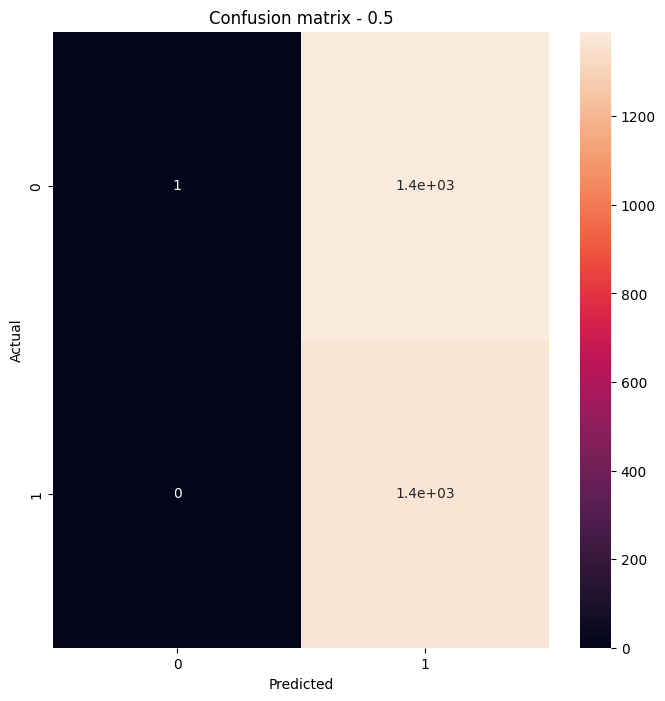

In [ ]:
#Visualize the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

Now lets do a ROC plot

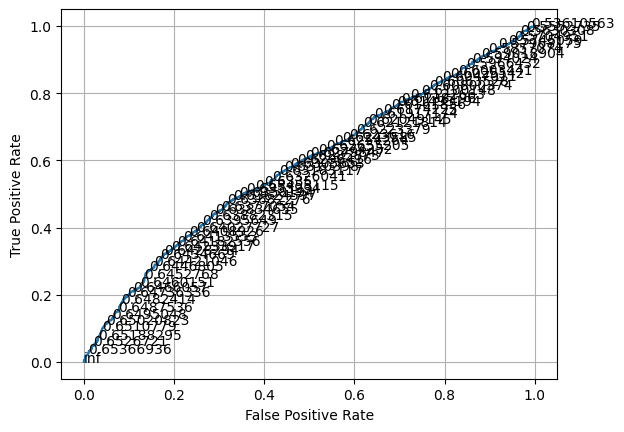

In [ ]:
fp, tp, thresholds = roc_curve(labels, predicted)

#fp, tp and threshold for each point

plt.plot(fp, tp)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.grid()

skip = 20

for i in range(0, len(thresholds), skip):
  plt.text(fp[i], tp[i], thresholds[i]) #Matplotlib text feature for every skip steps, otherwise too many

plt.show()

#Focus on top left portion and pick one of the thresholds

#ROc stands for receive operating characteristics

#Improving Model Performance (Tensor Flow Callbacks)

Callbacks are methods we call during traning, evaluating, predicting. It can permit us to extract useful information from those processes.

We've used the history callback already without knowing.

If you want to build a callback from scratch, use the callback mother class.

In [ ]:
class LossCallback(Callback): #Inherits from callback
  def on_epoch_end(self, epoch, logs): #Print out loss values at the end of the epoch
    print("\n Epoch Number {} has a loss of {}".format(epoch+1, logs["loss"])) #logs is a dictionary

  #I hashtagged the below because it crashes my computer

  # def on_batch_end(self, batch, logs): #Print information after every batch
  #   print("\n Batch Number {} has a loss of {}".format(batch+1, logs))

#Can create a CSV Logger which sends logging information to a file

csv_callback = CSVLogger('logs.csv', separator=',', append=False) #append False means overwrite, true is add to the file, can then compare different training methods

In [ ]:
#Now whenever you compile model

history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1, callbacks = [LossCallback(),csv_callback,es_callback,scheduler_callback,checkpoint_callback, plateau_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.5708 - auc: 0.6026 - fn: 2490.0769 - fp: 2304.6851 - loss: 70.2573 - precision: 0.5748 - recall: 0.5653 - tn: 3206.0493 - tp: 3039.1858
 Epoch Number 1 has a loss of 21.996776580810547
689/689 ━━━━━━━━━━━━━━━━━━━━ 105s 131ms/step - accuracy: 0.5708 - auc: 0.6026 - fn: 2493.7854 - fp: 2308.2463 - loss: 70.1873 - precision: 0.5748 - recall: 0.5653 - tn: 3210.4797 - tp: 3043.4363 - val_accuracy: 0.5056 - val_auc: 0.5000 - val_fn: 0.0000e+00 - val_fp: 1362.0000 - val_loss: 4.8050 - val_precision: 0.5056 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 1393.0000 - learning_rate: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 2/10
688/689 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5436 - auc: 0.5659 - fn: 2658.2327 - fp: 2421.4272 - loss: 10.4634 - precision: 0.5507 - recall: 0.5146 - tn: 3081.360

ValueError: The output of the `schedule` function should be a float. Got: 0.09048373997211456

By the way you run the model eagerly by setting on the kwargs in history to say run_eagerly=True. The other way is the graph mode which is faster, more efficient but harder to debug.

Early stopping callback is something to consider because we may get overfitting. Very dangerous if training accuracy becomes very high. If validation accuracy stays around constant or doesnt increase, but training accuracy increases then we should stop training. Or if training loss reduces, and validation loss stops decreasing. Or training precision increases but validation process doesn't.



Callbacks can modify training process in an automatic manner.

In [ ]:
es_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=2,
                            verbose=1, mode='auto', baseline=None, restore_best_weights=True)

#We're monitoring val loss.
#Min delta is the change below which we consider no improvement
#Patience, we're defining the number of epochs above which if we dont have a decrease in val loss, then we stop (our tolerance)
#mode: 'auto' will automatically determine, 'min' will stop once we reach minima
#baseline: training stops if model doesn't show improvement over the baseline
#restore_best_weights: True means go back to the last epoch where we considered improvement



#Run the above history run

**Learning Rate Scheduling**

To avoid local minima and approach convergence faster, we could start with a high learning rate and then later decrease with number of epochs to prevent divergence.

Do this automatically with a callback.

From now on all callbacks will be added to the history object above


Use MXNet website for a bunch of ideas for learning rate changes. One is an increasing linear function followed by a decaying exponential.

In [ ]:

def schedule(epoch, lr):
  if epoch <= 3:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

scheduler_callback = LearningRateScheduler(schedule, verbose=1)

#schedule is a method telling us how to change the learning rate

**Model Checkpointing**

argument explanation:

filepath- where we save model
monitor- what we monitor
verbose-
save_best_only- Only save the best model or save latest as well
save_weights_only- Or the whole model
mode-
save_freq ='epoch' save every epoch

In [ ]:
checkpoint_callback = ModelCheckpoint('checkpoints.keras', monitor='val_loss',
                                      verbose = 0, save_best_only=False,
                                      save_weights_only=False, mode='auto', save_freq='epoch')

If for a fixed number of epochs our performance doesn't improve, then use reducelronplateau callback to reduce learning rate.

monitor-
factor- reduce learning rate by factor
patience- how many epochs to wait
verbose
mode
min_delta
cooldown- number of epochs to wait to resume normal operation after lr has been reduced.
min_lr- which we dont wanna drop below


In [ ]:
plateau_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2,
                                  verbose=1, mode='auto', min_delta=0.0001,
                                  cooldown=0, min_lr=0.1)
#

#PREVENTING OVERFITTING AND UNDERFITTING

**Overfitting**

Causes of overfitting is too little data (small dataset), and a complex model.

When there is a huge gap between our currennt loss from the minimum, or accuracy is far below 100% and plateaus then its called underfitting.

Our data is either too large, and/or our model is too simple. Or you could have a complex model but it hasnt been built in a way to extract useful information from the dataset.

--> Can fix overfitting by collecting more data, or use data augmentation.

You can modify each image slightly, by rotating/reflecting it for example, then we will have more data. Obviously for very complex data you need better techniques as rotating may give a different structure (reflecting usually works).
We could crop a portion, add some noise, add a filter, change the brightness etc. There are many data augmentation strategies.

--> Another way to fix overfitting is dropout, turning off some of the neurons.

--> Another way is regularization. Establish a prior on the weights/constrain its range to prevent it from being adjusted to fit the datapoints too perfectly, limiting its freedom.

Now make the loss = loss + lambda * sum of weights

L1 reg- is sum of abs of weights
L2 reg- is sum of square of weights

lambda is a regularization constant/parameter. L1 leads to sparse models as we need to minimize the regulation part (abs sum of weights, so some of the weights will go to 0).

--> Early stopping is also a way we showed above


--> Tune our hyperparameters (batch size, dropout rate, regularization rate, learning rate)

Smaller batch sizes have an effect of regularization < 32, not larger, even though its faster

Too low learning rate leads to overfitting.

--> Normalization layer, batch norm induces a regularization effect.

**For Underfitting**

--> Increase model complexity
--> Collect more data (diverse data and representative of population)
--> More training time, even though it looks like its plateauing, it may start decreasing later. Dont give them
--> Hyperparameter tuning
--> Normalization stabilizes training

-Dropouts

arguments:

Dropout is applied to each layer

dropout rate- % of neurons dropped out in decimal (its random)
noise_shape- None (adding noise)
seed- set to none instantly, but if you want to reproduce the experiment then set it to something.

Now look back at the model we created and below ###### we put our dropout layer and dropout rate

In [ ]:
#Dont run this its an example

dropout_rate = 0.2


Dropout(dropout_rate)

Now L2 regularizer, you specify regularization rate

In Conv2D you specify now keyword kernel_regularizer = L2(0.01)

samething with L1. Adding to both Conv 2D layers and the Dense Layers

#Data Augmentation

Use tf.image class.

Typically use random adjustment.

After cropping we can resize it to get the shape needed to pass into model again.

Run this stuff before taking batch sizes in the training dataset.

In [ ]:
def visualize(original, augmented):
  plt.subplot(1,2,1) #1 line 2 columns, and occupy the 1st position in the 2 columns
  plt.imshow(original)

  plt.subplot(1,2,2) #augmented on the 2nd column
  plt.imshow(augmented)

In [ ]:
original_image, label = next(iter(train_dataset)) #takes one element from our dataset

Use tensor flow image module methods to augment image

In [ ]:
augmented_image = tf.image.flip_left_right(original_image) #flip left right

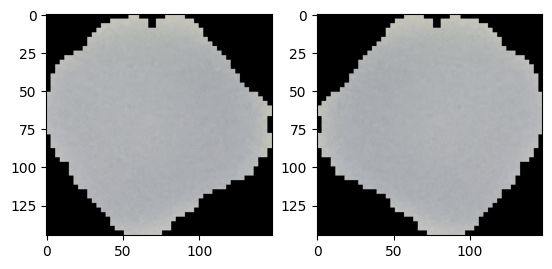

In [ ]:
visualize(original_image, augmented_image)

#Our dataset now multiplies by 2

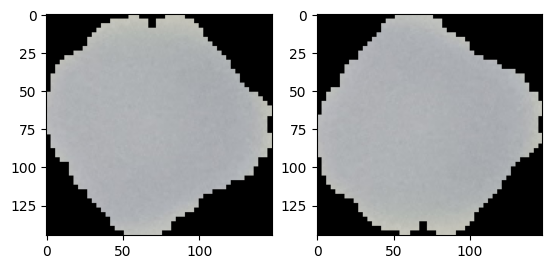

In [ ]:
augmented_image = tf.image.random_flip_up_down(original_image) #flip up down, randomly flips it up and down (can use a seed to replicate)
visualize(original_image, augmented_image)

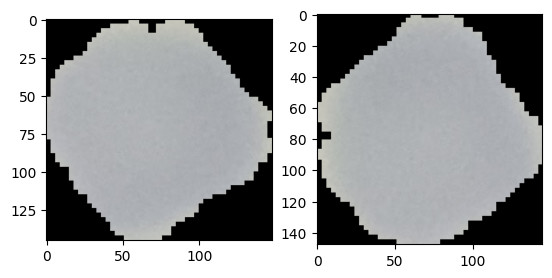

In [ ]:
augmented_image = tf.image.rot90(original_image) #rotates by 90 degrees CCW
visualize(original_image, augmented_image)

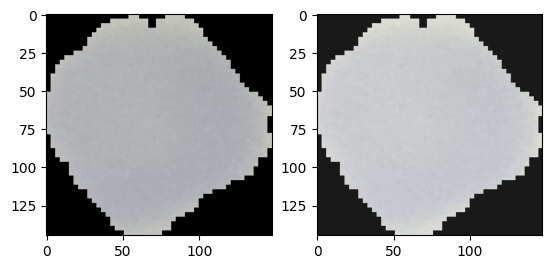

In [ ]:
augmented_image = tf.image.adjust_brightness(original_image, delta=0.1) #adjust brightness
visualize(original_image, augmented_image)

#delta is beteen -1 and 1, it adds to every pixel some number to brighten it

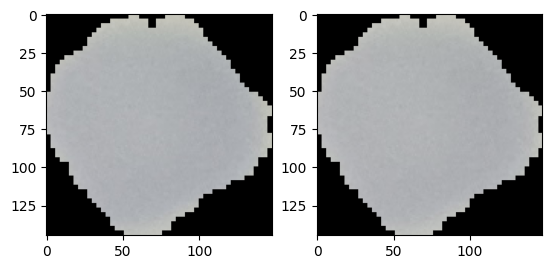

In [ ]:
augmented_image = tf.image.random_saturation(original_image, lower=0, upper=1) #adjust saturation randomly (lower/upper is the factor)
visualize(original_image, augmented_image)

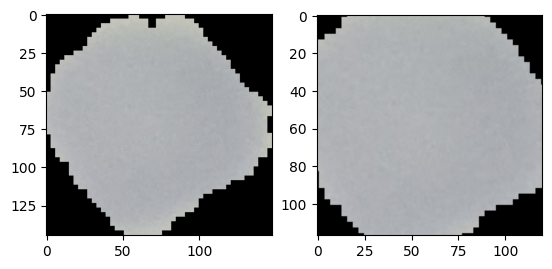

In [ ]:
augmented_image = tf.image.central_crop(original_image, central_fraction=0.8) #crop image
visualize(original_image, augmented_image)

#Central fraction is the portion of image to keep but this is centered on the center.
#If too low you'll just get the cell and not the borders

We will augment before we resize and rescale and take batches.

In [ ]:
@tf.function
def augment(image, label):

  #Visualize first to check how it looks before augmenting
  image, label = resizing(image, label)
  image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32)) #k is a scalar defining number of times we rotate
  # image = tf.image.adjust_saturation(image, saturation_factor = 0.3)
  image = tf.image.stateless_random_saturation(image, 0.3, 0.5)
  # image = tf.image.flip_left_right(image)
  image = tf.image.stateless_random_flip_left_right(image)

  return image, label

In [ ]:
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [ ]:
#Now since we already rescaled in the augment function, no need to do it again:

train_dataset = train_dataset.map(augment)
val_dataset = val_dataset.map(resizing)
test_dataset = test_dataset.map(resizing)

In [ ]:
#Can do this after the shuffling as well so dont run the above

test_dataset = test_dataset.map(resizing)

batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).map(augment).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).map(resizing).batch(batch_size).prefetch(tf.data.AUTOTUNE)

#Not augmenting the validation daatset

If you run it now, data will perform poorly.

The kind of data we have, saturation is not a good idea because parasitized cells have patches and modifying contrast will make the paratisized cell look like the uninfected so this is not a good idea. Create a subplot to visualize. So remove the saturation and then it'll be okay. But still need to reduce gap between training and validation accuracy.

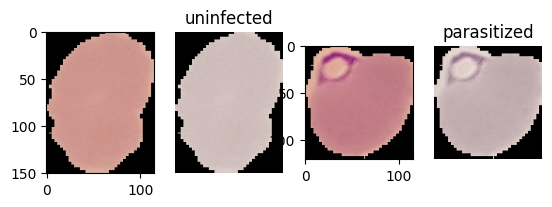

In [ ]:
for i, (image, label) in enumerate(train_dataset.take(2)):
  plt.subplot(1, 4, 2*i + 1)
  plt.imshow(image)

  plt.subplot(1, 4, 2*i + 2)
  plt.imshow(tf.image.adjust_saturation(image, saturation_factor = 0.3))

  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')


**Another way to do data augmentation is through keras rather than tf.image**

We have similar methods.

In [ ]:
class RotNinety(Layer):
  def __init__(self):
    super().__init__()

  @tf.function
  def call(self, image):
    return tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32))

In [ ]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (0.25, 0.2501),),
    RandomFlip(mode='horizontal',),
    RandomContrast(factor=0.2),
])


# tf.keras.layers.RandomRotation(factor)

#factor is a tuple representing the range as a fraction of 2pi or a fraction which represents that range about 0
#positive is CCW
#Supports a seed and the rest of arguments are default values


#Something similar with RandomFlip

#This is weird though so define a class which inherits from keras layers, so create a class above.

augment_layers = tf.keras.Sequential([
    RotNinety(),
    RandomFlip(mode='horizontal',),
    RandomContrast(factor=0.2)
])

In [ ]:
@tf.function #Actually its useless up there because we have called it here on a big-function so it applies to all smaller functions inside
def augment_layer(image, labels):
  image, label = resizing(image, label) #Carries the decorator automatically
  return augment_layers(image, training = True), labels

Now when taking the batches map the training input to augment_layer instead of augment

Also instead of using tf.image to resize our images, we could use a keras layer

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_SIZE, IM_SIZE),
    Rescaling(1.0/2.55),
])

def augment_layer(image, labels):
  return augment_layers(resize_rescale_layers(image), training = True), labels

Now what if we implement the resizing and rescaling layers in the model itself, so its very flexible on the data it takes in. Don't include the augment layers here as we usually dont augment during training time, takes too long.

All we need to do is out the resize_rescale_layers and augment_layers in the model, and make the input shape none as we accept any size.

Now we dont need to resize, rescale, the validation, testing and training set.

You'll face an error, to fix take batch sizes of 1 (will take longer).

Now its easy to run infernence. Use openCV (open computer vision), good for image processing.

In [ ]:
# image = cv2.imread('cell.jpg')
# image = tf.expand_dims(image, axis=0) #Add batch dimension

# lenet_model.predict(image) #No need to rescale

Now in practice for each image, we dont pass the rotated version, saturated version and flipped version into the dataset, this requires us to create more samples. However, we can just choose to randomly flip, contrast or rotate every epoch. So lets change the tf function.

##Mixed Sample Data Augmentation

Now we'll learn how to create a new sample based on a combination (mixture) of several samples. This will create more images that come from a similar distribution from the original dataset.

The way we combine them is a weighted addition with

X' = l * X1 + (1-l) * X2

Now when we mix labels from different classes we need to modify the label of our new class

so y' = l * y1 + (1-l) * y2

lambda is drawn from a beta distribution.




tf.Tensor([0.00291774], shape=(1,), dtype=float32)


(<matplotlib.image.AxesImage at 0x7875b3401510>,
 <matplotlib.image.AxesImage at 0x7875b3463340>)

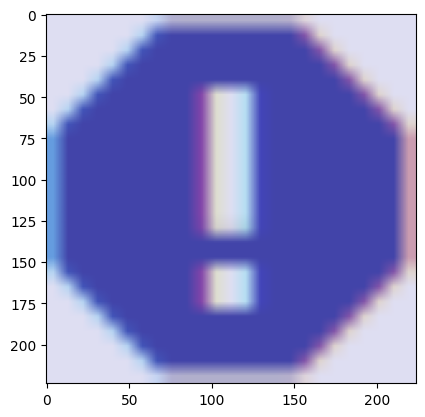

In [ ]:
lamda = tfp.distributions.Beta(0.2, 0.2) #parameters alpha and beta is 0.2 from the mixup paper

lamda = lamda.sample(1)

image_1 = cv2.resize(cv2.imread('cell.jpg'), (IM_SIZE, IM_SIZE))
image_2 = cv2.resize(cv2.imread('dog.jpg'), (IM_SIZE, IM_SIZE))
label_1, label_2 = 0, 1
image = lamda * image_1 + lamda * image_2
label = lamda * label_1 + lamda * label_2

print(label)
plt.imshow(image / 255), plt.imshow(image_1), plt.imshow(image_2)

Apply to dataset

In [ ]:
train_dataset_1 = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).map(resizing)
train_dataset_2 = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).map(resizing)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))
mixed_dataset

<_ZipDataset element_spec=((TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None)), (TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None)))>

In [ ]:
def mixup(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]

  image = lamda*image_1 + (1-lamda)*image_2
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)
  return image, label

Now we pass the mixed dataset into training

In [ ]:
BATCH_SIZE = 32
train_dataset = (
    mixed_dataset
    .shuffle(buffer_size = 8, reshuffle_each_iteration = True)
    .map(mixup)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [ ]:
val_dataset = (
    val_dataset
    .map(resizing)
    .batch(BATCH_SIZE)
)

val_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None))>

Accuracy is poor so mixup augmentation does not work wel.

##Cut-mix augmentation

Similar to mixup augmentation but we cut a random portion of one image and attach the data to that portion of another image.

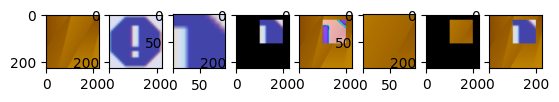

In [ ]:
plt.subplot(1, 8, 1)
image_1 = cv2.resize(cv2.imread('cell.jpg'), (IM_SIZE, IM_SIZE))
plt.imshow(image_1)

plt.subplot(1, 8, 2)
image_2 = cv2.resize(cv2.imread('dog.jpg'), (IM_SIZE, IM_SIZE))
plt.imshow(image_2)

plt.subplot(1, 8, 3)
crop = tf.image.crop_to_bounding_box(image_2, 20, 100, 100, 98)
plt.imshow(crop) #Cropped portion

plt.subplot(1, 8, 4)
image_4 = tf.image.pad_to_bounding_box(crop, 20, 100, IM_SIZE, IM_SIZE)
plt.imshow(image_4) #Padded portion

plt.subplot(1, 8, 5)
image_5 = image_4 + image_1
plt.imshow(image_5)

plt.subplot(1, 8, 6)
crop = tf.image.crop_to_bounding_box(image_1, 20, 100, 100, 98)
plt.imshow(crop)

plt.subplot(1, 8, 7)
x = tf.image.pad_to_bounding_box(crop, 20, 100, IM_SIZE, IM_SIZE)
plt.imshow(x)

plt.subplot(1, 8, 8)
plt.imshow(image_1 - x + image_4)

Use image crop to bounding box method. Arguments are offset height is the vertical coordinate of the top left corner of the bounding box, offset width will be the horizontal coordinate of the top left corner of the bounding box. target height and width are the size of the box.

To add the image use image pad to bounding box method, first arg is the cropped image, 2nd arg is offset height then offset width then the image dimensions.

Now we need to add back the rest of the image.

We draw r_x, r_y from a uniform dsitribution (0, W) and (0, H)

But we draw r_w and r_h (width and height) as W * sqrt(1 - lambda) and
H * sqrt(1-lambda), where lamda is from a beta distribution.

r_x, r_y are coordinate ceenters of the box initially, but we transform it to be the top left corner, we need to clip r_x to ensure the top left corner. Same for r_y.

We need to clip the bottom right corner as welland readjust the width and height.

The origin is on the top left corner of the bounding box.

In [ ]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, IM_SIZE) #first arg is tensor to clip, 2nd in clip_min, 3rd clip_max
  r_y = tf.clip_by_value(r_y - r_h//2, 0, IM_SIZE)

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, IM_SIZE)
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, IM_SIZE)

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [ ]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, IM_SIZE, IM_SIZE)

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, IM_SIZE, IM_SIZE)

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(IM_SIZE*IM_SIZE), dtype = tf.float32) #from paper
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

In [ ]:
BATCH_SIZE = 32
train_dataset = (
    mixed_dataset
    .shuffle(buffer_size = 8, reshuffle_each_iteration = True)
    .map(cutmix)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

tf.Tensor(
[1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00 7.9264987e-01
 1.0000000e+00 0.0000000e+00 9.6484375e-01 1.0000000e+00 1.0000000e+00
 1.9907951e-05 9.0784436e-01 7.5444436e-01 2.4115115e-01 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.8367344e-01 1.9907951e-05 0.0000000e+00
 9.9968112e-01 0.0000000e+00 6.7044020e-02 1.2755394e-03 0.0000000e+00
 8.0070156e-01 9.9982065e-01 1.6868621e-01 2.4555564e-01 1.0542870e-02
 9.9121094e-01 1.0000000e+00], shape=(32,), dtype=float32)


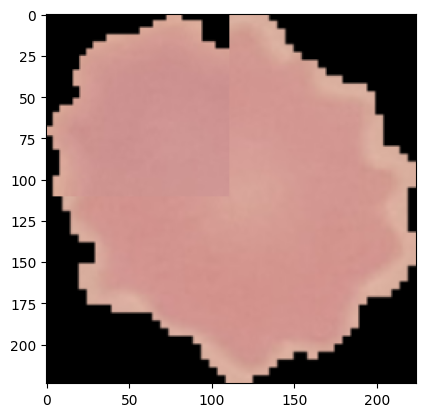

In [ ]:
original_image, label = next(iter(train_dataset))
print(label)
plt.imshow(original_image[0])

This is a risky method for this dataset, as the model may get confused when you crop different parts, mix images etc. Therefore for some datasets, some augmentation strategies work, some don't/

##Data Augmentation with Albumentations

Albumentations is a specialized data augmentation library, can be used in tensor flow and py torch.

In [ ]:
transforms = A.Compose([
      A.Resize(IM_SIZE, IM_SIZE),
      A.OneOf([A.HorizontalFlip(),
                A.VerticalFlip(),], p = 0.3), #randomly choose one of them

      A.RandomRotate90(),
      A.RandomGridShuffle(grid=(3, 3), always_apply=False, p=0.5),
      A.RandomBrightnessContrast(brightness_limit=0.2,
                                contrast_limit=0.2,
                                always_apply=False, p=0.5),
      A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.5),
])

In [ ]:

def aug_albument(image):
  data = {"image":image} #Creates a dictionary
  image = transforms(**data) #Pass the image through the transformations
  image = image["image"]
  image = tf.cast(image/255., tf.float32)
  return image



def process_data(image, label):
    #tf.numpy wraps a python function with a tensor flow operation
    aug_img = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32)
    return aug_img, label

In [ ]:
BATCH_SIZE = 32
train_dataset = (
    train_dataset
    .shuffle(buffer_size = 8, reshuffle_each_iteration = True)
    .map(process_data)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

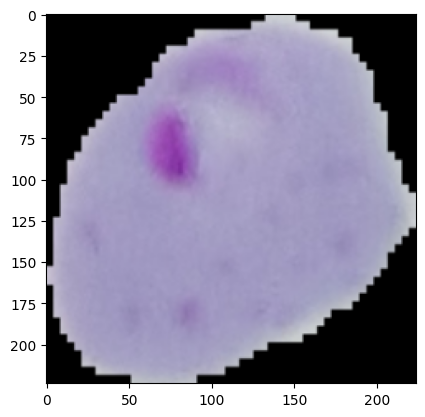

In [ ]:
im, _ = next(iter(train_dataset))
plt.imshow(im[0])

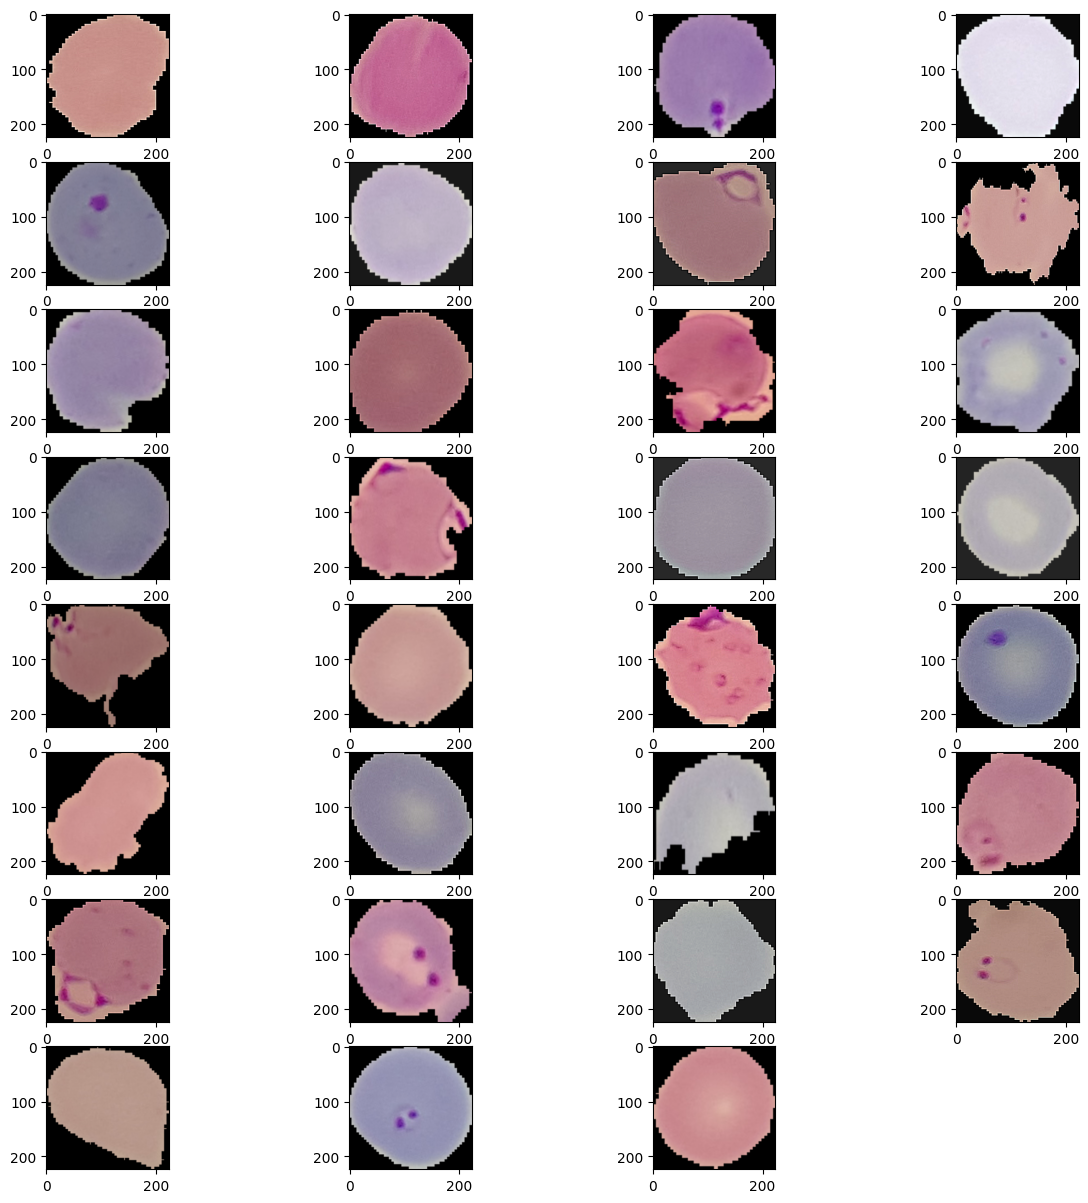

In [ ]:

plt.figure(figsize=(15,15))

for i in range(1,32):
  plt.subplot(8,4,i)
  plt.imshow(im[i])


The accuracy now increases, so the data augmentation strategy is good.

#Custom Loss and Metrics

In order to having to search through all the code to run it. I will re write the main parts of our code here.

In [ ]:
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [ ]:
train_dataset = train_dataset.map(resizing)
val_dataset = val_dataset.map(resizing)
test_dataset = test_dataset.map(resizing)

batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
IM_SIZE = 224
reg_rate = 0.01
dropout_rate = 0.2
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu', kernel_regularizer=L2(reg_rate))(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)
x = Dropout(dropout_rate)(x)

x = Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu', kernel_regularizer=L2(reg_rate))(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)

feature_extractor = Model(func_input, output, name = "Feature_Extractor")
feature_extractor.summary()

In [ ]:
IM_SIZE = 224
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_extractor(func_input)
#TF models are callable like layers in TF

x = Flatten()(x)

x = Dense(100, activation="relu", kernel_regularizer=L2(reg_rate))(x)
x = BatchNormalization()(x)

x = Dense(10, activation="relu", kernel_regularizer=L2(reg_rate))(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

lenet_model = Model(func_input, func_output, name = "Lenet_Model")
lenet_model.summary()

We are going to create custom metrics and loss functions

##Custom Loss Functions

Used when the function we need does not exist

In [ ]:
def custom_bce(y_true, y_pred):
  bce = BinaryCrossentropy()
  return bce(y_true, y_pred)

Then just pass the function into the loss argument as custom_bce(). We can include additional arguments (parameters) in the loss function in that case we need to do it like below.

In [ ]:
factor = 1

def custom_bce(factor):
  def loss(y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred) * factor
  return loss

In [ ]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.1), loss = custom_bce(factor), metrics=metrics)

Now we could build a loss class inheriting from the keras loss class

In [ ]:
class CustomBCE(tf.keras.losses.loss):
  def __init__(self, factor):
    super(CustomBCE, self).__init__()
    self.factor = factor

  def call(self, y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred) * self.factor

#This is essentially the same thing as before

In [ ]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.1), loss = CustomBCE(factor), metrics=metrics) #Same thing but as a class

##Custom Metric Functions

Similar method to above.

In [ ]:
def custom_accuracy(y_true, y_pred):
  return binary_accuracy(y_true, y_pred)

In [ ]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.1), loss = custom_bce(factor), metrics=custom_accuracy)

Now if we want to include parameters and additional arguments

In [ ]:
def custom_accuracy(factor):
  def accuracy(y_true, y_pred):
    return binary_accuracy(y_true, y_pred) * factor
  return accuracy

lenet_model.compile(optimizer = Adam(learning_rate = 0.1), loss = custom_bce(factor), metrics=custom_accuracy(factor))

Build a custom metric class. However, we need to redfine the accuracy attribute that comes from the inherited class. We will also have 3 different methods, update_state permits us to update the metric state, result outputs the metric values and reset_states allows us to reset the metric values.

To the accuracy we assign a given value which is our accuracy method.

Reset states will reset at the end of the epoch so assign 0.

Binary accuracy returns tensor of 1 if correct and 0 in position whereprediction is incorrect so we need to count.

In [ ]:
class CustomAccuracy(tf.keras.metrics.Metric):
  def __init__(self, name='Custom_Accuracy', factor = 1):
    super(CustomAccuracy, self).__init__()
    self.factor = factor
    self.accuracy = self.add_weight(name = name, initializer = 'zeros')

  def update_state(self, y_true, y_pred, sample_weight = None):
    o = binary_accuracy(tf.cast(y_true, dtype=tf.float32), y_pred) * self.factor)
    self.accuracy.assign(tf.math.count_nonzero(o, dtype=tf.float32)/tf.cast(len(o), dtype=tf.float32))
    return self.accuracy

  def result(self):
    return self.accuracy

  def reset_states(self):
    self.accuracy.assign(0)
    return self.accuracy

In [ ]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.1), loss = custom_bce(factor), metrics=customAccuracy(factor))

In [ ]:
metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
           BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

lenet_model.compile(optimizer = Adam(learning_rate = 0.1), loss = custom_bce(factor), metrics=metrics)

In [ ]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1, callbacks = [LossCallback(),csv_callback,es_callback,scheduler_callback,checkpoint_callback, plateau_callback])

#Eager and Graph Modes

In the graph mode, data is passed into different nodes. These nodes represent operations so the data gets modified as it passes through each node. The output of a node is sent to every other node it is connected to. Tf takes the python code and converts into this graph mode operations.

In the case where you do not have the python interpreter, you can still run the program in a different environment as the code is now portable. All that matters is the operations. Also the graph can be broken into several parallel blocks making it easier for parallelization. These are advantages of graph mode.

In order to convert a method/function into a graph, just add the @tf-function decorator.

So now we will go back in the code and add the decorator.



Now notice if you write a print command inside a function with the decorator, and you call the function 5 times, it will only print once. This is because the first time we call the function, it carries out tracing which converts the code into the graph mode. Next time we call it it will already be in graph mode, which only focusses on the data operations.

Now you can change it back to eagerly mode very easily (easier for debugging).

In [ ]:
tf.config.run_functions_eagerly(True) #all functions will be run eagerly

Now graph modes have a specialized print function if you want. Ensure that graph modes are only used with tensor flow operations, otherwise you will get error. You should avoid passing python variables into methods.

In [ ]:
tf.print("ABC")

#Custom Training Loop

Tensor flow keeps track of gradients as it passes through the network. Training is slower in eager mode than in graph mode. The following resets the metric and updates when necessary.

In [ ]:
@tf.function
def training_block(x_batch, y_batch):
   with tf.GradientTape as tape: #recording gradients in tape
      y_pred = lenet_model(x_batch, training=True) #in training mode, pass x_batch
      loss = custom_bce(y_batch, y_pred)

    partial_derivatives = tape.gradient(loss, model.trainable_weights) #Finds derivative losss wrt each weight

    optimizer.apply_gradients(zip(partial_derivatives, model.trainable_weights)) #grad desc

    metric.update_state(y_batch, y_pred)

    return loss

@tf.function
def val_block(x_batch_val, y_batch_val):

    y_pred_val = lenet_model(x_batch_val, training=False)
    val_loss = custom_bce(y_batch_val, y_pred_val)
    metric_val.update_state(y_batch_val, y_pred_val)

    return val_loss

In [ ]:
optimizer = Adam(learning_rate = 0.01)
epochs = 3
metric = CustomAccuracy(factor)
metric_val = CustomAccuracy(factor)

def learn(model, loss_function, metric, metric_val, optimizer, train_dataset, val_dataset, epochs):
  for epoch in epochs:
    print(f"EPOCH NUMBER {epoch}")
    for step, (x_batch, y_batch) in enumerate(train_dataset): #Go through each and every batch

      loss = training_block(x_batch, y_batch_)

      if step % 300 == 0:
        print("TRAIN LOSS: ", loss)

    print(f"Accuracy is {metric.result()}")
    metric.reset_states()

    for (x_batch_val, y_batch_val) in val_dataset:
      val_loss = val_block(x_batch_val, y_batch_val)

    print(f"Val Accuracy is {metric_val.result()}")
    metric_val.reset_states()

    print("VALIDATION LOSS: ", val_loss)

In [ ]:
learn(lenet_model, custom_bce, metric, metric_val, optimizer, train_dataset, val_dataset, epochs)